In [1]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
solver = pyo.SolverFactory("cplex", tee=True, time_limit=60)

In [3]:
number_of_apartments = pd.read_excel(
    "Housing Problem - parameter values.xlsx", sheet_name="number_of_apartments"
)
number_of_apartments.head()

,area,configuration,no_of_apartments
0,36,aa,4
1,36,ab,2
2,36,ac,2
3,36,bb,0
4,36,bc,0


In [4]:
HEIGHT = 69

profits = pd.read_excel(
    "Housing Problem - parameter values.xlsx", sheet_name=f"profit_height_{HEIGHT}"
)
profits.head()

,sector,area,owner,profit
0,social,36,corporation,-25085.659379
1,social,36,investor,14925.772676
2,social,36,private,-213932.318684
3,social,42,corporation,-27602.151343
4,social,42,investor,-12842.016761


In [5]:
sectors = profits["sector"].unique()
owners = profits["owner"].unique()
areas = profits["area"].unique()
floor_configurations = number_of_apartments["configuration"].unique()

In [6]:
from typing import Any


O: dict[tuple[str, int, str], float] = {
    (i, j, h): profits[
        (profits["sector"] == i) & (profits["owner"] == h) & (profits["area"] == j)
    ]["profit"].values[0]
    for i in sectors
    for j in areas
    for h in owners
}

R: dict[tuple[int, str], int] = {
    (j, v): number_of_apartments[
        (number_of_apartments["configuration"] == v)
        & (number_of_apartments["area"] == j)
    ]["no_of_apartments"].values[0]
    for j in areas
    for v in floor_configurations
}

# Minimal floor area for sector s and owner o
alpha: dict[tuple[str, str], int] = {(s, o): 0 for s in sectors for o in owners}
alpha[("social", "corporation")] = 40
alpha[("middle", "corporation")] = 50
alpha[("free", "investor")] = 60
alpha[("free", "corporation")] = 60
alpha[("free", "private")] = 60

# Fraction of apartments in sector s
beta: dict[str, float] = {s: 0.0 for s in sectors}
beta["social"] = 0.4
beta["middle"] = 0.4

# Minimum average floor area for each sector
gamma: dict[str, float] = {s: 0.0 for s in sectors}
gamma["social"] = 40
gamma["middle"] = 50

# Minimum fraction of apartments that are owned by that owner
delta: dict[str, float] = {o: 0.0 for o in owners}
delta["investor"] = 0.7

# Number of floors
f_max = {69: 23, 120: 40, 168: 56}

In [7]:
model = pyo.ConcreteModel()

# Sets
model.I = pyo.Set(initialize=sectors)
model.J = pyo.Set(initialize=areas)
model.H = pyo.Set(initialize=owners)
model.V = pyo.Set(initialize=floor_configurations)

# Variables
# Number of floors with configuration v
model.x = pyo.Var(model.V, domain=pyo.NonNegativeIntegers)
# Number of apartments in sector i with floor area j and owner h
model.y = pyo.Var(model.I, model.J, model.H, domain=pyo.NonNegativeIntegers)
# Number of floors of type v with owner h
model.w = pyo.Var(model.V, model.H, domain=pyo.NonNegativeIntegers)

# Paramters
model.O = pyo.Param(model.I, model.J, model.H, initialize=O, mutable=True)
model.R = pyo.Param(model.J, model.V, initialize=R, mutable=True)
model.alpha = pyo.Param(model.I, model.H, initialize=alpha, mutable=False)
model.beta = pyo.Param(model.I, initialize=beta, mutable=True)
model.gamma = pyo.Param(model.I, initialize=gamma, mutable=True)
model.delta = pyo.Param(model.H, initialize=delta, mutable=True)
model.f_max = pyo.Param(initialize=f_max[HEIGHT], mutable=True)


@model.Objective(sense=pyo.maximize)
def objective_function(m):
    return pyo.quicksum(
        m.y[i, j, h] * O[i, j, h] for i in m.I for j in m.J for h in m.H
    )


### Added by me
# The sum over all X_v should be equal to the total number of floors
@model.Constraint(model.V)
def total_number_of_floors(m, v):
    return pyo.quicksum(m.x[v] for v in m.V) == model.f_max


### From "correct" model


@model.Constraint(model.J)
def total_apartment_consistency(m, j):
    return pyo.quicksum(m.x[v] * model.R[j, v] for v in m.V) == pyo.quicksum(
        m.y[i, j, h] for i in m.I for h in m.H
    )


@model.Constraint(model.V)
def owner_floor_configuration(m, v):
    return pyo.quicksum(m.w[v, h] for h in m.H) == m.x[v]


@model.Constraint(model.J, model.H)
def no_floors_with_multiple_owners_and_apartments_by_owner_and_area(m, j, h):
    return pyo.quicksum(m.w[v, h] * model.R[j, v] for v in m.V) == pyo.quicksum(
        m.y[i, j, h] for i in m.I
    )


@model.Constraint(model.I)
def minimal_percentage_of_a_sector(m, i):
    return pyo.quicksum(m.y[i, j, h] for j in m.J for h in m.H) >= model.beta[
        i
    ] * pyo.quicksum(m.y[l, j, h] for l in m.I for j in m.J for h in m.H)


@model.Constraint(model.I)
def minimal_average_floor_in_sector(m, i):
    return pyo.quicksum(m.y[i, j, h] * j for j in m.J for h in m.H) >= model.gamma[
        i
    ] * pyo.quicksum(m.y[i, j, h] for j in m.J for h in m.H)


@model.Constraint(model.I, model.H, model.J)
def minimal_floor_area_for_sector_and_owner(m, i, h, j):
    if j < model.alpha[i, h]:
        return m.y[i, j, h] == 0
    return pyo.Constraint.Skip


@model.Constraint(model.J)
def no_free_sector_with_corporation_owner(m, j):
    return m.y["free", j, "corporation"] == 0


@model.Constraint(model.H)
def sector_ownership_requirement(m, h):
    return pyo.quicksum(m.y[i, j, h] for i in m.I for j in m.J) >= model.delta[
        h
    ] * pyo.quicksum(m.y[i, j, p] for i in m.I for j in m.J for p in m.H)

In [8]:
results = solver.solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmp2qmbsxoj
  Lower bound: 17483910.863021515
  Upper bound: 17485640.214
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 134
  Number of nonzeros: 965
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.38
  Termination condition: optimal
  Termination message: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = 1.7483910863e+07
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 8772
      Number of created subproblems: 8772
  Error rc

In [23]:
beta_social_values = np.linspace(0.0, 0.6, 13)
beta_social_objective = []
# Run the model with different values of beta_social
for beta_social in beta_social_values:
    beta_social = round(beta_social, 2)
    model.beta["social"] = beta_social
    solver.solve(model)
    beta_social_objective.append(model.objective_function())


model.beta["social"] = beta["social"]
# Run the model with different values of beta_middle
beta_middle_values = np.linspace(0.0, 0.6, 13)
beta_middle_objective = []
for beta_middle in beta_middle_values:
    beta_middle = round(beta_middle, 2)
    model.beta["middle"] = beta_middle
    solver.solve(model)
    beta_middle_objective.append(model.objective_function())

Text(0.5, 1.0, 'Objective Function vs Beta, scaled to Beta = 0.4')

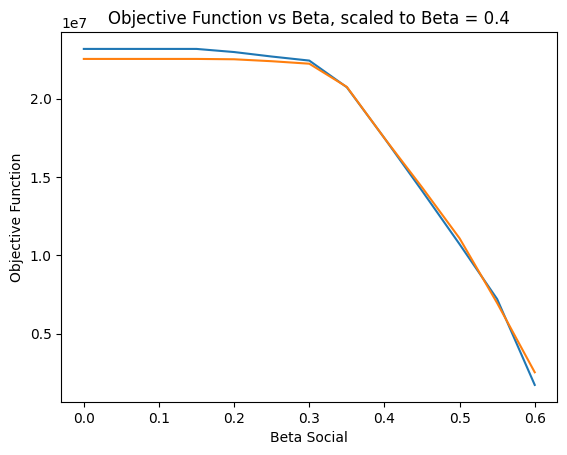

In [25]:
plt.plot(beta_social_values, beta_social_objective, label="Beta Social")
plt.plot(beta_middle_values, beta_middle_objective, label="Beta Middle")
plt.xlabel("Beta Social")
plt.ylabel("Objective Function")
plt.title("Objective Function vs Beta")

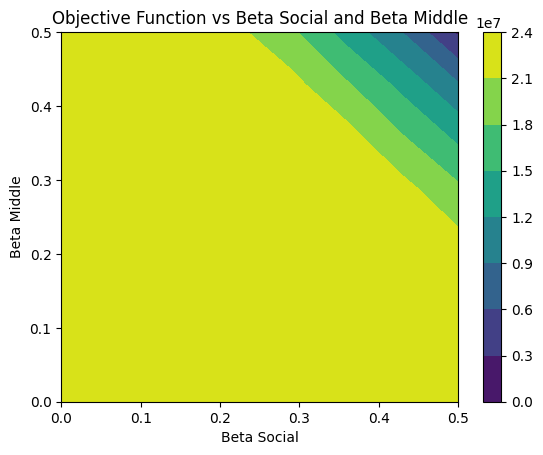

In [10]:

beta_social_values = np.linspace(0.2, 0.6, 8)
beta_middle_values = np.linspace(0.2, 0.6, 8)
beta_social_middle_objective = np.zeros((len(beta_social_values), len(beta_middle_values)))
for i, beta_social in enumerate(tqdm(beta_social_values, leave=False, position=0)):
    for j, beta_middle in enumerate(beta_middle_values):
        if beta_social + beta_middle > 1:
            continue
        model.beta["social"] = beta_social
        model.beta["middle"] = beta_middle
        solver.solve(model)
        beta_social_middle_objective[i, j] = model.objective_function()

# Reset the beta values
model.beta["social"] = beta["social"]
model.beta["middle"] = beta["middle"]

plt.contourf(beta_social_values, beta_middle_values, beta_social_middle_objective)
plt.xlabel("Beta Social")
plt.ylabel("Beta Middle")
plt.title("Objective Function vs Beta Social and Beta Middle")
plt.colorbar()


  0%|          | 0/8 [00:00<?, ?it/s]

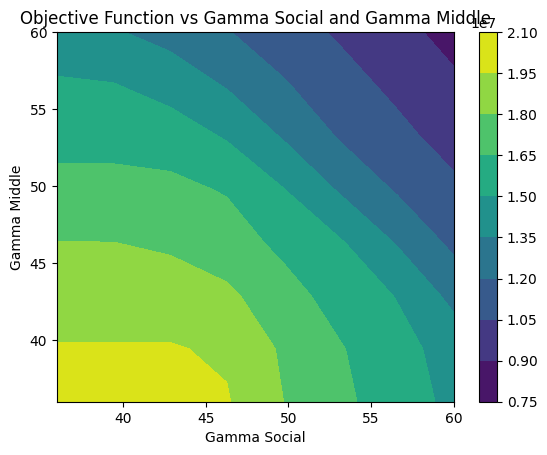

In [8]:
# Test different values of gamma
gamma_social_values = np.linspace(36, 60, 8)
gamma_middle_values = np.linspace(36, 60, 8)
gamma_social_middle_objective = np.zeros((len(gamma_social_values), len(gamma_middle_values)))
for i, gamma_social in enumerate(tqdm(gamma_social_values, leave=False, position=0)):
    for j, gamma_middle in enumerate(gamma_middle_values):
        model.gamma["social"] = gamma_social
        model.gamma["middle"] = gamma_middle
        solver.solve(model)
        gamma_social_middle_objective[i, j] = model.objective_function()

plt.contourf(gamma_social_values, gamma_middle_values, gamma_social_middle_objective)
plt.xlabel("Gamma Social")
plt.ylabel("Gamma Middle")
plt.title("Objective Function vs Gamma Social and Gamma Middle")
plt.colorbar()